In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

Powder Diffraction

In [2]:
def gauss(x, A, x0, sigma):
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def fit_gaussian(x, y, p0):
    popt, pcov = curve_fit(gauss, x, y, p0)
    return (popt[1], popt[2])

In [17]:
a = 5.64e-10
def print_out_data(mu, sigma, n, wavelength):
    print(
        f'{mu:.2f}',
        f'{sigma:.2f}',
        f'{mu / 2:.2f}',
        f'{sigma / 2:.2f}',
        f'{2 * a / (n * wavelength) * np.sin(np.radians(mu / 2)):.2f}',
        f'{sigma / 2 * 2 * a / (n * wavelength) * np.cos(np.radians(mu / 2)):.2f}'
    )

In [11]:
columns = ['2theta', 'intensity']
nacl_powder = pd.read_csv('data/NaCi_powder.tsv', sep='\t', skiprows=1, encoding='unicode_escape')
nacl_powder.columns = columns

Text(0.5, 1.0, 'NaCl Powder Diffraction')

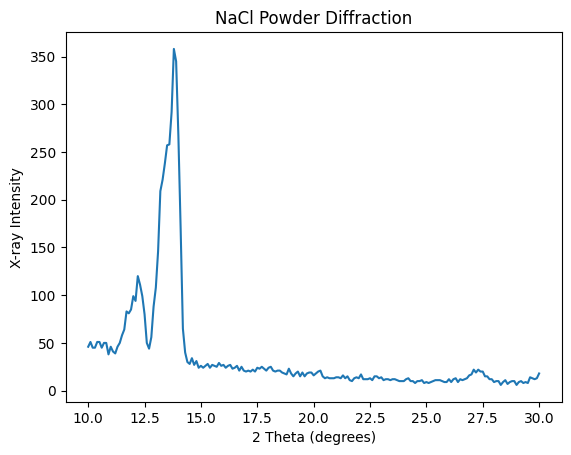

In [13]:
plt.plot(
    nacl_powder['2theta'], 
    nacl_powder.intensity
)
plt.xlabel('2 Theta (degrees)')
plt.ylabel('X-ray Intensity')
plt.title('NaCl Powder Diffraction')

Peak 1
12.22 1.50 6.11 0.75 0.86 6.05


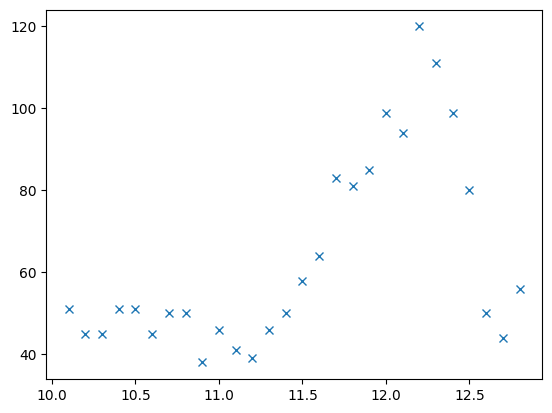

In [18]:
data = nacl_powder[(nacl_powder['2theta'] > 10) & (nacl_powder['2theta'] < 12.9)]
plt.plot(
    data['2theta'],
    data['intensity'],
    'x'
)
mu, sigma = fit_gaussian(
    data['2theta'],
    data['intensity'],
    [1000, 12, 1]
)

print("Peak 1")
print_out_data(
    mu, sigma, 1, 1.39e-10
)


Peak 2
13.66 0.41 6.83 0.20 0.96 1.63


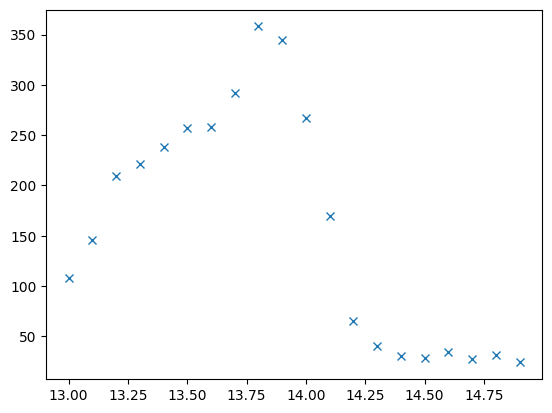

In [20]:
data = nacl_powder[(nacl_powder['2theta'] > 12.9) & (nacl_powder['2theta'] < 15)]
plt.plot(
    data['2theta'],
    data['intensity'],
    'x'
)
mu, sigma = fit_gaussian(
    data['2theta'],
    data['intensity'],
    [1000, 13.5, 1]
)

print("Peak 2")
print_out_data(
    mu, sigma, 1, 1.39e-10
)


Peak 3
27.27 1.04 13.64 0.52 1.91 4.10


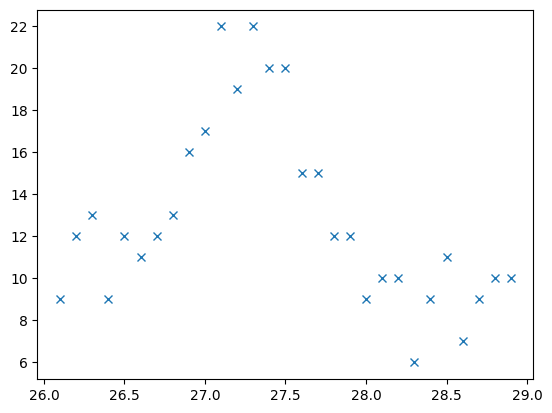

In [23]:
data = nacl_powder[(nacl_powder['2theta'] > 26) & (nacl_powder['2theta'] < 29)]
plt.plot(
    data['2theta'],
    data['intensity'],
    'x'
)
mu, sigma = fit_gaussian(
    data['2theta'],
    data['intensity'],
    [1000, 27, 1]
)

print("Peak 3")
print_out_data(
    mu, sigma, 1, 1.39e-10
)